# ECoG Spectrogram Forecasting with Sequence-to-Sequence (seq2seq) RNN models.

## Starting small: 1 channel.

In [1]:
#!/usr/bin/env python
# coding: utf-8

from aopy import datareader, datafilter
from ecog_is2s import EcogDataloader, Training, Encoder, Decoder, Seq2Seq, Util

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler, BatchSampler, SubsetRandomSampler
from torch.utils.data import TensorDataset, random_split
from torch.nn.modules.loss import _Loss
from torch.nn.functional import mse_loss

import spacy
import numpy as np
import pandas as pd
# import sklearn
import scipy as sp

import random
import math
import time

# import progressbar as pb
import datetime
import os
import sys
import pickle as pkl

from itertools import product

import argparse
import matplotlib.pyplot as plt

# modules that aren't done yet
sys.path.append('/Users/mickey/aoLab/code/analyze/')
# sys.path.append('/home/mickey/analyze/')
from tfspec import tfspec

The code in the next cell is used to parse command line arguments. These arguments assign values to the network and training parameters. This functionality has been replaced with more hard-coded constants in the current notebook. From an organizational standpoint, that's not the worst thing - it's given me a good opportunity to collect all of the constants together into one single code block @ the top of the notebook. They were pretty scattershot before that.

In [2]:
# # grab input arguments
# parser = argparse.ArgumentParser('Trains a seq2seq network on a section of example NHP PMC ECoG data.',add_help=True)
# parser.add_argument('--encoder-depth', metavar='el', type=int, default=10, help='Sequence depth of the encoder network')
# parser.add_argument('--decoder-depth', metavar='dl', type=int, default=1, help='Sequence depth of the decoder network')
# parser.add_argument('--batch-size', metavar='b', type=int, default=1, help='Data batch size')
# parser.add_argument('--num-epochs', metavar='n', type=int, default=1, help='Number of optimization epochs')
# parser.add_argument('--num-layers', metavar='nl', type=int, default=1, help='Number of layers in each RNN block')

# args = parser.parse_args() # this bad boy has all the values packed into it. Nice!
# print(args.encoder_depth,args.decoder_depth)

# print(args.encoder_depth,args.decoder_depth)

In [3]:
# define constants
T_MINUTES = 30
ENCODER_DEPTH = 30
DECODER_DEPTH = 30
BATCH_SIZE = 100
NUM_EPOCHS = 500
N_EPOCHS = NUM_EPOCHS
RNG_SEED = 5050
INPUT_SEQ_LEN = ENCODER_DEPTH
OUTPUT_SEQ_LEN = DECODER_DEPTH
N_CH_USE = 1
N_LAYER = 1
DROPOUT = np.float32(0.3)
ENC_DROPOUT = np.float32(DROPOUT)
DEC_DROPOUT = np.float32(DROPOUT)
LEARN_RATE = 0.001 # default ADAM: 0.001
LOSS_OBJ = 'MSE' #L1, L2, see training.py:ECOGLoss()
WEIGHT_RANGE = (-0.2,0.2) # ignore for now; not sure how to worm this through
train_frac = 0.5
test_frac = 0.5
valid_frac = 0.0
# BATCH_SIZE = args.batch_size
# N_EPOCHS = args.num_epochs
CLIP = 1. # this the maximum norm of the whole parameter gradient.
TFR = 0.0 # no teacher forcing! Anything it's learning is all on its own
RAND_SAMP = False
weight_reg = 0.#0.0003
enc_len = ENCODER_DEPTH
dec_len = DECODER_DEPTH
seq_len = ENCODER_DEPTH+DECODER_DEPTH # use ten time points to predict the next time point

In [4]:
# seed RNG for pytorch/np
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
torch.cuda.manual_seed(RNG_SEED)
torch.backends.cudnn.deterministic = True # enforces deterministic algorithm use -> reproducibility. Remove for production code. You don't do production code. Don't remove.

In [5]:
# set device - CUDA if you've got it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('mounting to device: {}'.format(device))

mounting to device: cpu


In [6]:
# load data
platform_name = sys.platform
if platform_name == 'darwin':
    # local machine
    data_file_full_path = '/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.lfp.dat'
    mask_file_path = "/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
    model_save_dir_path = '/Volumes/Samsung_T5/aoLab/Data/models/pyt/seq2seq/'
elif platform_name == 'linux2':
    # HYAK, baby!
    data_file_full_path = '/gscratch/stf/manolan/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = "/gscratch/stf/manolan/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
elif platform_name == 'linux':
    # google cloud, don't fail me now
    data_file_full_path = '/home/mickey/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = '/home/mickey/rec001.LM1_ECOG_3.clfp.mask.pkl'
    model_save_dir_path = '/home/mickey/models/pyt/seq2seq/'

# make sure the output directory actually exists
if not os.path.exists(model_save_dir_path):
    os.makedirs(model_save_dir_path)

data_in, data_param, data_mask = datareader.load_ecog_clfp_data(data_file_name=data_file_full_path)
srate_in = data_param['srate']
num_ch = data_param['num_ch']

Loading data file:


In [7]:
# mask data array, remove obvious outliers
# data_in[:,np.logical_or(data_mask["hf"],data_mask["sat"])] = 0.

# downsample data
srate_down = 250
srate = srate_in

# grab local time segment
total_len_T = T_MINUTES*10
total_len_n = total_len_T*srate_in
# data_idx = data_in.shape[1]//2 + np.arange(total_len_n)
print('Downsampling data from {0} to {1}'.format(srate_in,srate_down))
### note: this breaks mask indexing, if you plan to do that later.
data_in = np.float32(sp.signal.decimate(data_in[:N_CH_USE,:],srate_in//srate_down,axis=-1))
data_in = np.float32(data_in[:N_CH_USE,:])
data_in = data_in*1e-3 # convert to mV
print('Data Size:\t{}\n'.format(data_in.shape))

# # filter dead channels
# ch_rms = np.std(data_in,axis=-1)
# ch_m = np.mean(ch_rms)
# ch_low_lim = ch_m - 2*np.std(ch_rms)
# ch_up_lim = ch_m + 2*np.std(ch_rms)
# ch_idx = np.logical_and(ch_rms > ch_low_lim, ch_rms < ch_up_lim)
# ch_list = np.arange(num_ch)[ch_idx]
# num_ch_down = len(ch_list)
# print('Filtering Channels:')
# print('Num. ch. used:\t{}'.format(num_ch_down))
# print('Ch. kept:\t{}\n'.format(ch_list))

Downsampling data from 1000 to 250
Data Size:	(1, 1801794)



In [8]:
# compute data spectrogram
tapers = [4,1];
dn = 0.5;
# T = 60
sgram, f_sgram, ti, err = tfspec(data_in, tapers=tapers, sampling=srate_down, dn=dn,fk=(0,120), contflag=False);
t_sgram = ti/srate_down

['Using ', [4, 4, 7], ' tapers.']


In [9]:
# filter bad regions by spectrogram power
print('Detecting bad spectrogram regions')
db_power = np.clip(10*np.ma.log10(sgram).mean(axis=-1)[0,:],a_min=-50,a_max=np.inf)
db_power_mean = db_power.mean()
db_power_std = db_power.std()
std_k = 0.25
bad_sgram_idx = (db_power.data < db_power_mean - 3*std_k*db_power_std) | \
                (db_power.data > db_power_mean + std_k*db_power_std) | \
                (db_power.mask)
print('{}% retained'.format(100-bad_sgram_idx.mean()*100))

Detecting bad spectrogram regions
87.1858947660697% retained


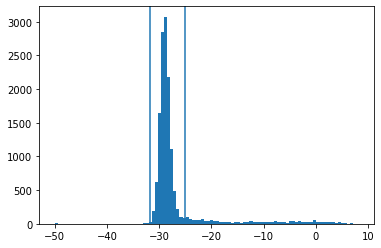

In [10]:
plt.hist(db_power,100)
plt.axvline(db_power_mean - 3*std_k*db_power_std)
plt.axvline(db_power_mean + std_k*db_power_std)

In [11]:
# define function for spectrogram plotting; forgive the misnomer
def plot_log_psd(ax,psd,x,y,clim,cmap='viridis',cb_label='dB'):
    # create norm from clim
    norm = plt.Normalize(vmin=clim[0],vmax=clim[1])
    # get axes extent from x, y
    extent = (x.min(), x.max(), y.min(), y.max())
    # plot the figure
    im_h = ax.imshow(10*np.log10(psd),extent=extent,norm=norm,origin='bottom',aspect='auto')
    # add a colorbar
    cb_h = plt.colorbar(im_h, ax=ax, label=cb_label, pad=0.01)
    
    return im_h, cb_h

In [12]:
# define function for spectrogram plotting; forgive the misnomer
def plot_psd(ax,psd,x,y,clim,cmap='viridis',cb_label='power'):
    # create norm from clim
    norm = plt.Normalize(vmin=clim[0],vmax=clim[1])
    # get axes extent from x, y
    extent = (x.min(), x.max(), y.min(), y.max())
    # plot the figure
    im_h = ax.imshow(psd,extent=extent,norm=norm,origin='bottom',aspect='auto')
    # add a colorbar
    cb_h = plt.colorbar(im_h, ax=ax, label=cb_label, pad=0.01)
    
    return im_h, cb_h

Text(0.5, 0, 'time (s)')

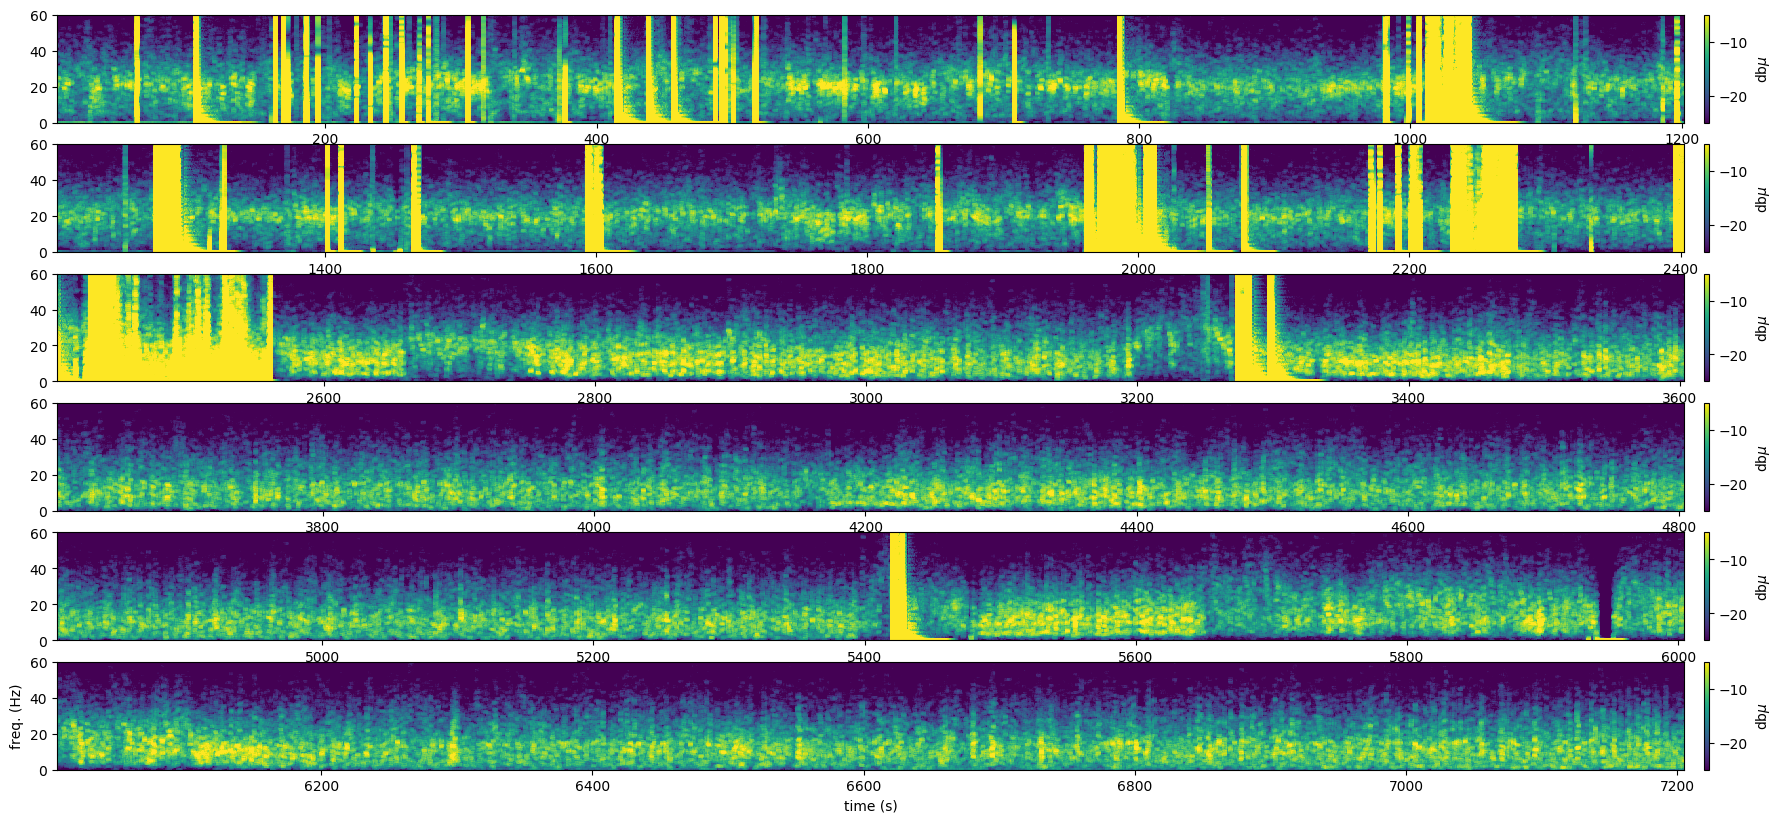

In [13]:
n_col = 6
f,ax = plt.subplots(n_col,1,figsize=(25,10),dpi=100)
n_win = sgram.shape[1]
n_win_per_row = n_win//n_col
clim = (-25,-5)
for k in range(n_col):
    plot_idx = np.arange(k*n_win_per_row,(k+1)*n_win_per_row)
    plot_log_psd(ax[k],sgram[:,plot_idx,].mean(axis=0).T,t_sgram[plot_idx],f_sgram,clim,cb_label='db$\mu$')
    ax[k].set_ylim(0,60)
ax[-1].set_ylabel('freq. (Hz)')
ax[-1].set_xlabel('time (s)')

## Creating a dataset/tensor from the spectrogram data
Spectrogram data is a $n_{ch}\times n_{win}\times n_{freq}$ array, so creating a pytorch tensor, dataset and loader from a spectrogram is not very complicated. However, doing that in a way that plays well nicely with recurrent neural network models is less straightforward, primarily because of the variability in frequency band power across the spectrogram and the requirement of normalized data inputs.

How should I do this? It's an open question for me, but some paper probably has the answer.

In [14]:
# create dataset
#create data tensor
print('Normalizing data, converting to tensor:')
data_rail = np.max(np.abs(data_in.reshape(-1)))
# normalization = 'zscore'
# normalization = 'tanh'
# if normalization is 'max':
#     data_tensor = torch.from_numpy(data_in.view().T/data_rail)
# elif normalization is 'zscore':
#     # for nominally gaussian data distributions, this will get ~99% of data points in (-1, 1)
#     data_tensor = torch.from_numpy(sp.stats.zscore(data_in.view().T)/5)
# elif normalization is 'tanh':
#     data_tensor = torch.from_numpy(np.tanh(sp.stats.zscore(data_in.view().T)/3))
# print('Data tensor shape: {}\n'.format(data_tensor.shape))
N_FREQ_BINS = -1
n_sgram_win = sgram.shape[-1]
freq_range = (1, 80)
freq_idx = (f_sgram >= freq_range[0]) & (f_sgram <= freq_range[1])
mean_sgram = np.log10(sgram[0,~bad_sgram_idx,:]).mean(axis=0)
log_sgram_ceil = np.log10(sgram[0,~bad_sgram_idx,:])[:,freq_idx].max()
log_sgram_floor = np.log10(sgram[0,~bad_sgram_idx,:])[:,freq_idx].min()
log_sgram_mid = (log_sgram_ceil + log_sgram_floor)/2
log_sgram_range = log_sgram_ceil - log_sgram_floor
# PCA_REDUCE = False
NORMALIZE_DATA = True
if NORMALIZE_DATA:
#     data_array = ((np.log10(sgram[0,])-log_sgram_mid)/log_sgram_range*1.8)[:,freq_idx]
    mean_psd = sgram.mean(axis=(0,1))
    data_array = sp.stats.zscore(np.log10(sgram),axis=(0,1))[0,]
else:
    data_array = np.log10(sgram[0,:,freq_idx]).T
# if PCA_REDUCE:
#     k = 6
#     data_cov = np.cov(data_array[np.logical_not(bad_sgram_idx),:].T)
#     data_cov_eigval, data_cov_eigvec = np.linalg.eig(data_cov)
#     data_tensor = torch.from_numpy(data_array.dot(data_cov_eigvec[:,:k]))
data_tensor = torch.from_numpy(np.float32(data_array))

Normalizing data, converting to tensor:


Text(0.5, 0, 'time (s)')

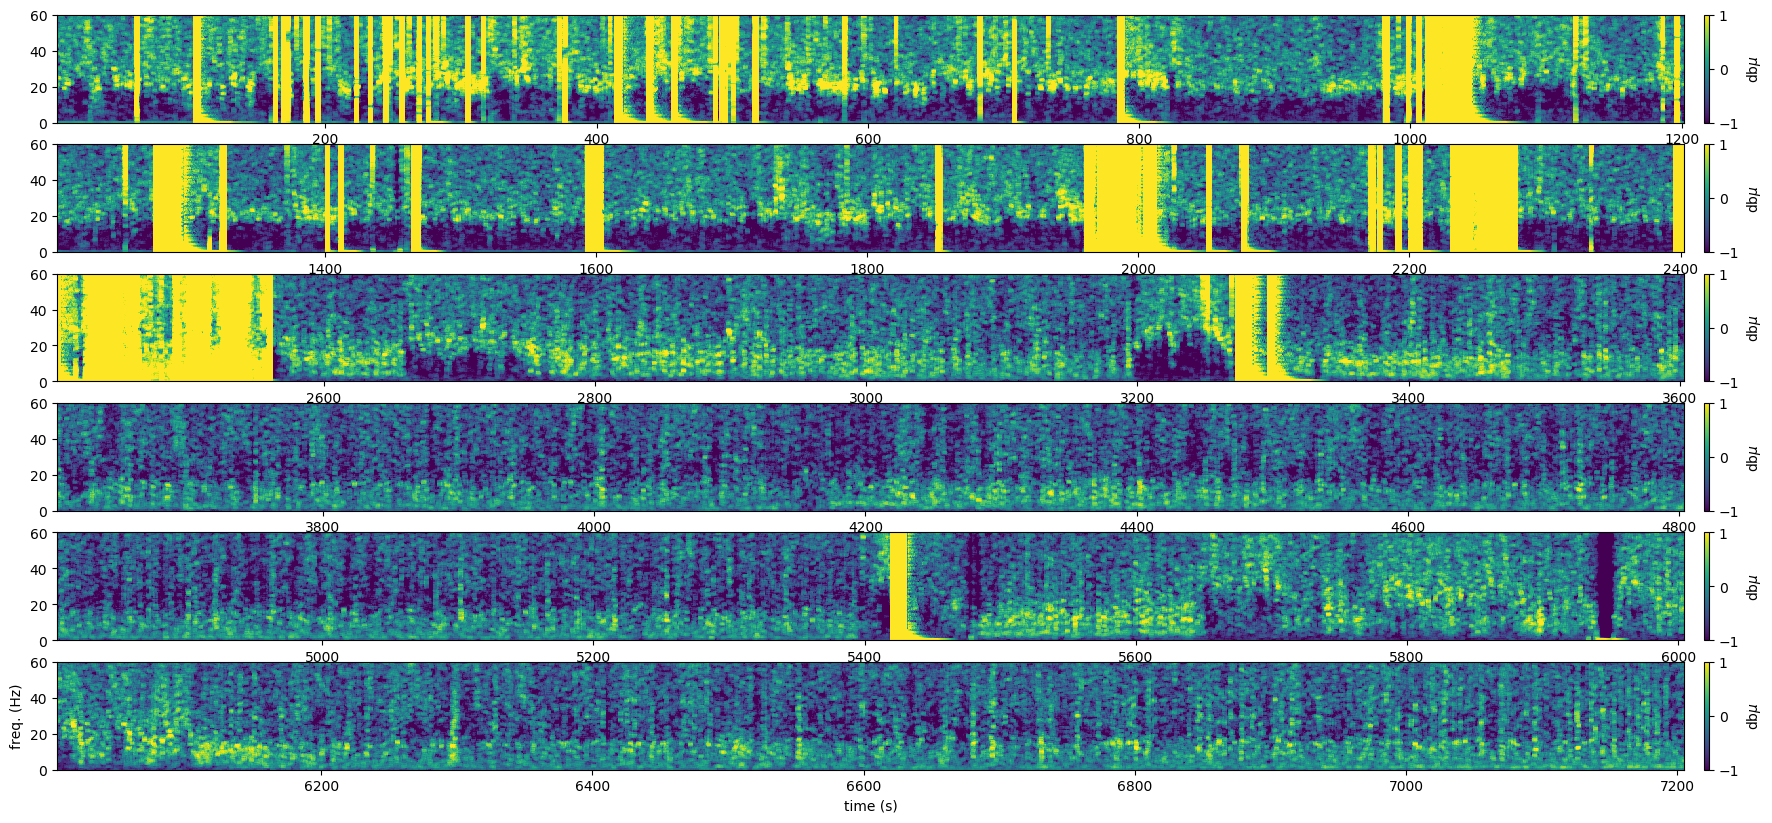

In [15]:
n_col = 6
f,ax = plt.subplots(n_col,1,figsize=(25,10),dpi=100)
n_win = sgram.shape[1]
n_win_per_row = n_win//n_col
clim = (-1, 1)
for k in range(n_col):
    plot_idx = np.arange(k*n_win_per_row,(k+1)*n_win_per_row)
    plot_psd(ax[k],data_tensor[plot_idx,].T,t_sgram[plot_idx],f_sgram,clim,cb_label='db$\mu$',cmap='rb')
    ax[k].set_ylim(0,60)
ax[-1].set_ylabel('freq. (Hz)')
ax[-1].set_xlabel('time (s)')

In [16]:
# create dataset object
print('Creating EcogDataloader dataset object:')
if device == 'cuda:0':
    data_tensor.cuda()
dataset = EcogDataloader.EcogDataset(data_tensor,device,seq_len) ## make my own Dataset class
num_ch_down = dataset.n_ch
print('\n')

Creating EcogDataloader dataset object:




In [17]:
idx_all = np.arange(dataset.data.shape[0])
idx_step = DECODER_DEPTH
sample_idx = idx_all[:-seq_len:idx_step]
n_win = sample_idx.shape[0]
idx_cut = np.zeros((n_win),dtype=bool)
for k in range(n_win):
    idx_cut[k] = np.any(bad_sgram_idx[sample_idx[k]:(sample_idx[k]+seq_len)])
sample_idx = sample_idx[np.logical_not(idx_cut)]
# plot samples
n_plot_seed = 1
n_plot_step = 4*seq_len
plot_seed_idx = np.arange(0,n_plot_seed*n_plot_step,n_plot_step)

In [18]:
# simple progressbar, not tied to the iterator
def print_progress_bar(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

In [19]:
# get list of parameter tuples
n_hidden_list = [2**10]
n_layer_list = [2]
dropout_list = np.float32([0.3, 0.4, 0.5])
param_tuple_list = product(n_hidden_list,n_layer_list,dropout_list)
LEARN_RATE = 0.001
decay_scale = 0.2

In [ ]:
# sweep across parameterizations: create and train models on z-scored sgram data
n_win, n_freq = dataset.data.shape
INPUT_DIM = n_freq
OUTPUT_DIM = n_freq

time_str = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
sweep_output_path = os.path.join(model_save_dir_path,'enc{}_dec{}_nl{}_nep{}_hps_{}'.format(enc_len,dec_len,N_LAYER,N_EPOCHS,time_str))

for param_idx, (HID_DIM, N_LAYER, DROPOUT) in enumerate(param_tuple_list):
    if param_idx > 0:
        break
    # make network model
    model = Seq2Seq.Seq2Seq_GRU(INPUT_DIM, HID_DIM, N_LAYER, ENCODER_DEPTH, DECODER_DEPTH, device, dropout=DROPOUT).to(device)
    model.apply(Util.init_weights) # initialize the model each time.

    print(f'The model has {Util.count_parameters(model):,} trainable parameters')

    criterion = nn.MSELoss(reduction='mean')
    optimizer = optim.AdamW(model.parameters(),lr=LEARN_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=decay_scale)
    
    print(model)
    
    # train model and save outputs
    # train/test!
    best_test_loss = float('inf')

    train_loss = np.zeros(N_EPOCHS)
    train_batch_loss = []
    test_loss = np.zeros(N_EPOCHS)
    test_batch_loss = []
    print_train_loss = np.Inf
    print_test_loss = np.Inf
    
    learning_rate_history = np.zeros(N_EPOCHS)

    # create training session directory
    time_str = Util.time_str() # I may do well to pack this into util
    session_save_path = os.path.join(sweep_output_path,'hid{}_nl{}_d{:0.2f}'.format(HID_DIM, N_LAYER, DROPOUT))
    sequence_plot_path = os.path.join(session_save_path,'example_sequence_figs')
    os.makedirs(session_save_path) # no need to check; there's no way it exists yet.
    os.makedirs(sequence_plot_path)
    print('saving session data to:\t{}'.format(session_save_path))
    # save a histogram of the data distribution; allowing you to check
    f,ax = plt.subplots(1,1,figsize=(6,4))
    ax.hist(dataset.data.reshape(-1),100,density=True)
    f.savefig(os.path.join(session_save_path,'norm_data_hist.png'))

    # make figure (and a place to save it)
    f_loss = plt.figure()
    ax_loss = f_loss.add_subplot(1,1,1)

    for e_idx, epoch in enumerate(range(N_EPOCHS)):
        print_progress_bar(epoch,N_EPOCHS,status='epoch: {}\ttrain loss: {}\tvalid loss:{}'.format(epoch,print_train_loss,print_test_loss))

        start_time = time.time()

        # get new train/test splits
        # note: add switch to genLoaders to allow for fixed/random sampling
        train_loader, test_loader, _, plot_loader = EcogDataloader.genLoaders(dataset, sample_idx, train_frac
                                                                              , test_frac, valid_frac, BATCH_SIZE
                                                                              , rand_samp=RAND_SAMP, plot_seed=plot_seed_idx)
        _, trbl_ = model.train_iter(train_loader, optimizer, criterion, CLIP, TFR)
        train_batch_loss.append(trbl_)
        train_loss[e_idx] = np.mean(trbl_) # this is the plotted training loss
        _, tebl_ = model.eval_iter(test_loader, criterion)
        test_loss[e_idx] = np.mean(tebl_) # this is the plotted test loss
        learning_rate_history[e_idx] = optimizer.param_groups[0]['lr']
        scheduler.step(test_loss[e_idx])
        if not (epoch % 10):
            # save the data for the plotting window in dict form
            epoch_plot_path = os.path.join(sequence_plot_path,'epoch{}'.format(epoch))
            os.makedirs(epoch_plot_path)
            torch.save(model.state_dict(),os.path.join(epoch_plot_path,'model_epoch{}.pt'.format(epoch)))
            c_list = ['b','r']

        end_time = time.time()

        epoch_mins, epoch_secs = Util.epoch_time(start_time, end_time)

        if test_loss[e_idx] < best_test_loss:
            best_test_loss = test_loss[e_idx]
            torch.save({ # this needs to be made into a model class method!
                    'epoch': epoch,
                    'num_epochs': N_EPOCHS,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': best_test_loss,
                    'data_path': data_file_full_path,
                    'train_frac': train_frac,
                    'test_frac': test_frac,
                    'batch_size': BATCH_SIZE,
                    'encoder_length': enc_len,
                    'decoder_length': dec_len,
                    }, os.path.join(session_save_path,'model_checkpoint.pt'))
            
        if e_idx == 0:
            ax_loss.plot(e_idx,train_loss[e_idx],'b.',label='train loss')
            ax_loss.plot(e_idx,test_loss[e_idx],'r.',label='valid. loss')
            ax_loss.legend(loc=0)
        else:
            ax_loss.plot(e_idx,train_loss[e_idx],'b.')
            ax_loss.plot(e_idx,test_loss[e_idx],'r.')
            
        ax_loss.set_ylim(bottom=0,top=1.05*np.concatenate((train_loss,test_loss)).max())
        # print the loss curve figure; continuously overwrite (like a fun stock ticker)
        f_loss.savefig(os.path.join(session_save_path,'training_progress.png'))
        torch.save({'train_loss':train_loss,'test_loss':test_loss,},os.path.join(session_save_path,'training_progress.pt'))
        print_train_loss = train_loss[e_idx]
        print_test_loss = test_loss[e_idx]
    
    # replot with log-y scale 
    f_log_loss, ax = plt.subplots(2,1,figsize=(5,6),dpi=100,sharex=True)
    ax[0].plot(np.arange(epoch),train_loss[:epoch],'b.',label='train loss')
    ax[0].plot(np.arange(epoch),test_loss[:epoch],'r.',label='test loss')
    ax[0].set_yscale('log')
    ax[0].set_ylabel('MSE Loss')
    ax[0].set_title('Spectrogram Prediction Loss')
    ax[0].legend(loc=0)
    ax[1].plot(np.arange(epoch),learning_rate_history[:epoch])
    ax[1].set_xlabel('epochs/iters')
    ax[1].set_ylabel('Learning Rate')
    ax[1].set_title('Adaptive Learning Rate')
    f_log_loss.savefig(os.path.join(session_save_path,'training_progress_logscale.png'))

The model has 25,946,071 trainable parameters
Seq2Seq_GRU(
  (encoder): Encoder_GRU(
    (rnn): GRU(983, 1024, num_layers=2, batch_first=True, dropout=0.30000001192092896)
  )
  (decoder): Decoder_GRU(
    (rnn): GRU(983, 1024, num_layers=2, batch_first=True, dropout=0.30000001192092896)
    (dropout): Dropout(p=0.30000001192092896, inplace=False)
    (fc_out): Linear(in_features=1024, out_features=983, bias=True)
  )
)
saving session data to:	/Volumes/Samsung_T5/aoLab/Data/models/pyt/seq2seq/enc30_dec30_nl1_nep500_hps_20200718201405/hid1024_nl2_d0.30


In [ ]:
# replot with log-y scale 
f_log_loss, ax = plt.subplots(2,1,figsize=(5,6),dpi=100,sharex=True)
ax[0].plot(np.arange(epoch),train_loss[:epoch],'b.',label='train loss')
ax[0].plot(np.arange(epoch),test_loss[:epoch],'r.',label='test loss')
ax[0].set_yscale('log')
ax[0].set_ylabel('MSE Loss')
ax[0].set_title('Spectrogram Prediction Loss')
ax[0].legend(loc=0)
ax[1].plot(np.arange(epoch),learning_rate_history[:epoch])
ax[1].set_xlabel('epochs/iters')
ax[1].set_ylabel('Learning Rate')
ax[1].set_title('Adaptive Learning Rate')
f_log_loss.savefig(os.path.join(session_save_path,'training_progress_logscale.png'))

In [ ]:
# get sample
sample = dataset.__getitem__(sample_idx[-10])
src = sample[:30,].unsqueeze(0)
trg = sample[30:,].unsqueeze(0)
pred,enc,dec = model(src,trg)
# plot comparison
f_compare,ax = plt.subplots(1,3,figsize=(12,3))
asdf = ax[0].imshow(trg[0,].cpu().detach().T,clim=(-.75,0.3),aspect='auto',origin='lower',extent=(0,30,freq_range[0],freq_range[1]));
# ax[0].set_yticks(np.arange(0,700,100))
# ax[0].set_yticklabels(f_sgram[freq_idx][0:-1:100])
ax[0].set_title('Target')
asdf = ax[1].imshow(pred[0,].cpu().detach().T,clim=(-.75,0.3),aspect='auto',origin='lower',extent=(0,30,freq_range[0],freq_range[1]));
# ax[1].set_yticks(np.arange(0,700,100))
# ax[1].set_yticklabels(f_sgram[freq_idx][0:-1:100])
ax[1].set_title('Prediction')
asdf = ax[2].imshow(trg[0,].cpu().detach().T - pred[0,].cpu().detach().T,aspect='auto',origin='lower',extent=(0,30,freq_range[0],freq_range[1]),cmap='coolwarm');
cbax = f_compare.add_axes([0.95, 0.1, 0.015, 0.8])
plt.colorbar(asdf,cax=cbax)
ax[2].set_title('Difference')